# 第五回AI<画像/GPT>技術者育成講座
目次
- OpenAI APIのインストール
- 環境変数の設定
- 関数の定義
- 課題例①
- 課題例②

注意点
- この演習はGoogle Colaboratyで実行することを想定しています

## OpenAI APIのインストール (+必要なライブラリをインストール)

---


- [公式ドキュメント](https://platform.openai.com/docs/api-reference?lang=python)
- [GitHub](https://github.com/openai/openai-python)

In [1]:
# ライブラリのインストール
!pip install openai==1.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.3/220.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [2]:
# グラフを日本語フォントに対応させるライブラリ
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=f98dad4858bcc9f3aee0fd686f6a5413c08aafdd2a5aa9a3607be48ea55ef19e
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## 環境変数の設定
左のタブの`シークレット`から`OPENAI_API_KEY`を設定


<img width=500 src="https://github.com/HarmoLab/aitr/blob/main/2023/exercise_04/colab_secret.png?raw=true">

## 使用する関数の定義

In [3]:
import time

import pandas as pd
from google.colab import userdata
from openai import OpenAI
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

client = OpenAI(
    api_key= userdata.get('OPENAI_API_KEY')
)

In [4]:
# promptから料金を出力する関数
def calculate_credit(model:str, input_tokens:int, output_tokens:int) -> float:
    yen_rate = 150 # $1 = 150円で計算
    if model == "gpt-3.5-turbo-1106":
        input_credit = (0.001 * yen_rate) / 1000
        output_credit = (0.002 * yen_rate) / 1000
    elif model == "gpt-4-1106-preview":
        input_credit = (0.01 * yen_rate) / 1000
        output_credit = (0.03 * yen_rate) / 1000
    else:
        assert False, f"モデル名: {model}の料金計算はできません。modelは'gpt-3.5-turbo-1106',または'gpt-4-1106-preview'を使用してください。"
    total_credit = round(input_credit * input_tokens + output_credit * output_tokens, 2)
    print(f"使用したモデル: {model}, 料金: {total_credit}円")
    return total_credit


In [5]:
# forでループするために関数化 (RateLimit対策のためtenacityのデコーダを採用)
# 参考: https://cookbook.openai.com/examples/how_to_handle_rate_limits
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def simple_completion(system_prompt:str, user_prompt:str):
    model_name = "gpt-3.5-turbo-1106"
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": user_prompt
            },
        ],
        model=model_name,
        timeout=15
    )
    time.sleep(15)  # limit対策
    # 料金の計算
    credit = calculate_credit(model_name, response.usage.prompt_tokens, response.usage.completion_tokens)
    return response, credit

### chat.completions.createに使用する引数について
公式ドキュメント: https://platform.openai.com/docs/api-reference/chat/create

### 主要な引数
- model (必須)
    - 使用する学習モデル (本演習では"gpt-3.5-turbo-1106"を使用)
- messages (必須)
    - role
        - system: アシスタントの動作を設定
        - assistant: アシスタントの望ましい動作を設定 (ユーザも作成可)
        - user: ユーザの指示
    - content
        - roleに対して入力する文章
- max_tokens: int or null
    - 生成するトークンの最大数。出力の長さを制限することが可能
- n: int or null
    - 生成するレスポンスの数 (デフォルト: 1)
- temperature: number or null
    - 0～2の間で指定
    - 0に近づくにつれて決定論的になり、2に近づくにつれて生成文が多様でランダムになる（デフォルト: 1）
        - 詳しい説明: https://techblog.a-tm.co.jp/entry/2023/04/24/181232

## 演習課題例①: **Amazonのレビュー分類**
- 今回使用するデータセット (前回演習と同じデータ)
    - Amazon Reviews Multi:
https://huggingface.co/datasets/mteb/amazon_reviews_multi/viewer/ja

In [6]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.4 MB/s eta 0:00:00


In [7]:
import datasets
# Amazonレビューのデータセット(日本語)をダウンロード
# 今回はダウンロード時間を減らすために検証データ (validation)のみ取得
dataset = datasets.load_dataset("mteb/amazon_reviews_multi", "ja", split="validation")
print(dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 5000
})


### データの用意

In [8]:
k = 10 # 10件のレビュー文に対する評価
shuffled_dataset = dataset.shuffle(seed=70) # データセットをシャッフル

# 検証データ
review_list = shuffled_dataset[:k]["text"]
label_list = shuffled_dataset[:k]["label"]

# few-shotデータ
num_few_shot = 4  # few-shotの数
review_list_few_shot = shuffled_dataset[k: k + num_few_shot]["text"]
label_list_few_shot = shuffled_dataset[k: k + num_few_shot]["label"]

# テストデータ
test_review_list = shuffled_dataset[-k:]["text"]
test_label_list = shuffled_dataset[-k:]["label"]


print(review_list)
print(label_list)

['無難な一品\n\nC26セレナに装着。風切り音無し。 キャンプ道具積載量アップ。 ミニバンだと乗せおろしが大変。 スタンダードで無難。', '柔らかめの生地感ですごく良かったです\n\n先ほど到着したばかりで、妻に新年プレゼントの為に買いました。柔らかめの生地感ですごく良かったです。お値段も高くないし、良かったです。今後も利用するので、よろしくお願いします。', '大好きな香り！\n\n部屋には定期的に噴射する他社の芳香剤を置いていますが、これは人感センサーなのでトイレに置いています！人感センサーなので、トイレを使用した時だけいい香りにしてくれて無駄がありませんし、匂いも私の大好きな匂いでトイレがとてと心地よく感じられます！ 香りの持続力はありませんが、トイレに入ったら瞬時に噴射してくれるのでいつもいい香りをかいでます。', '品質が悪くなった！？\n\nリピーターです。品質が落ちたと思います。浴室に取付けて3ヶ月、既に鏡の淵の裏側から腐食が見られます。また、家族の身長によって上下に向きを変えるのですが、たびたび吸盤から鏡を止めているプラスチックボール部が外れて落下します。以前の物も落下はありましたが、吸盤のボール受け部分が浅くなったのか、ボールが大きくなったのかは古い方を捨てたので比較出来ませんが、新しいのにもかかわらず頻繁に落ちます。強く押し込んでも浮いて見えます。鏡が割れそうなほど強く押し込んでいるのですが。 まあ、落下しても淵のプラスチックの曲面が上手くショックを吸収するように作られている様で、以前のものは鏡自体は最後まで割れませんでした。経年で淵のプラスチックが硬化し、落下のたびにプラスチックの淵が割れていきました。ちなみに、浴室乾燥機はなく直射日光も当たらない環境での利用です。', 'スピード、名作です\n\nかなりの値引き時に購入。もともとDVD持っていたのですが、セットだったので再購入。満足の採用です。', 'コスパ良き\n\n物はいいけど３つ中１つの支えの１つが割れていた。ショートのウィッグを掛けるぶんには問題ないのでそのままつかっているけれど、少し残念なので星3。割れていない２つに関してはとても良い。総合的に見て、たまたま私が外れを引いたとしてもコスパは良いと思う。', '値段相応\n\n予想範囲内のコピー品です。予想の範囲内なので可ですが。

### 検証データによる評価

* 最も性能が良いプロンプトを見つける

#### zero-shotプロンプトを使用したレビューの分類

* 検証データを用いたレビュー分類
* 回答例を与えないzero-shotプロンプトを使用

In [9]:
# 以下のsystem prompt (zero-shotプロンプト) を用いたレビュー分類
system_prompt = """
レビュー文を0から4までの整数に分類してください。
"""

predict_label_list = [] # -1(出力形式のエラー), 0, 1, 2, 3, 4
total_credit = 0
for i, (review, label) in enumerate(zip(review_list, label_list)):
    print(f"\n^^^^^^^^^^ {i+1}件目のレビュー ^^^^^^^^^^")
    print("--- レビュー文 ---")
    print(review)
    print("--- 実際の評価 ---")
    print(label)
    response, credit = simple_completion(system_prompt, review)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    try:
        response_int = int(response.choices[0].message.content)
        predict_label_list.append(response_int)
    except ValueError:
        print("--- Error ---")
        print("回答がint型に変換できませんでした。")
        predict_label_list.append(-1)
        continue
print(f"合計金額: {total_credit}円")


^^^^^^^^^^ 1件目のレビュー ^^^^^^^^^^
--- レビュー文 ---
無難な一品

C26セレナに装着。風切り音無し。 キャンプ道具積載量アップ。 ミニバンだと乗せおろしが大変。 スタンダードで無難。
--- 実際の評価 ---
2
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.02円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbBtW8ARRDYwTmapfOtpioKweaXD', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='2', role='assistant', function_call=None, tool_calls=None))], created=1702303493, model='gpt-3.5-turbo-1106', object='chat.completion', system_fingerprint='fp_eeff13170a', usage=CompletionUsage(completion_tokens=1, prompt_tokens=104, total_tokens=105))
2

^^^^^^^^^^ 2件目のレビュー ^^^^^^^^^^
--- レビュー文 ---
柔らかめの生地感ですごく良かったです

先ほど到着したばかりで、妻に新年プレゼントの為に買いました。柔らかめの生地感ですごく良かったです。お値段も高くないし、良かったです。今後も利用するので、よろしくお願いします。
--- 実際の評価 ---
4
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.02円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbBvnVO8fkGAhKYR4nrdBdpRJ0mO', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='4', role='assistant', function_call=Non

In [10]:
print("--- 実際の評価 ---")
print(label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)
## 予測した評価が-1（出力形式のエラー）の場合は+6

validation_score = 0 # 評価値
correct_answer = 0 # 正解数
for actual, predict in zip(label_list, predict_label_list):
    if not actual == predict:
        if predict == -1:
            validation_score += 6
            continue
        validation_score += abs(actual - predict)
    else:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(label_list)*100} %")
print("--- 評価値 (低いほうが良い結果) ---")
print(validation_score)

--- 実際の評価 ---
[2, 4, 3, 1, 4, 2, 1, 2, 3, 2]
--- 予測した評価--- 
[2, 4, 3, -1, 3, -1, 3, -1, 3, 3]

--- 正答率 ---
40.0 %
--- 評価値 (低いほうが良い結果) ---
22


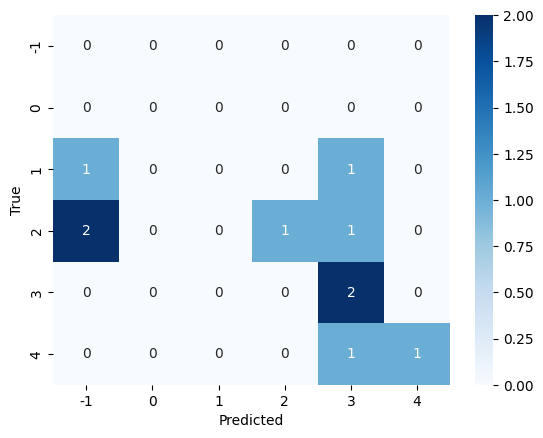

In [11]:
# 混同行列で結果を可視化
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 混同行列に使用するラベル作成
label_name = list(range(-1, 5))  # [-1, 0, .., 4]

# 混同行列の作成
confusion_mtr = confusion_matrix(label_list, predict_label_list, labels=label_name)

# ラベル名
label_name = list(range(-1, 5))

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### few-shotプロンプトを使ったレビューの分類

In [12]:
num_few_shot = 4  # few-shotで使用する回答例の数

# few-shotプロンプトに使用するデータ
review_list_few_shot = shuffled_dataset[k: k + num_few_shot]["text"]
label_list_few_shot = shuffled_dataset[k: k + num_few_shot]["label"]

print(review_list_few_shot)
print(label_list_few_shot)

['ヒト由来の乳酸菌\n\n体にもよさそうで値段も安いので喜んで食べてましたが、 ふと、「ヒト由来」って何よ？と思い調べてみました。 製品ホームページにも詳しくは書いてないですが、 実は・・・から採取、分離、培養してるそうです。 お客様相談室にも確認しました。 うーーん。', 'お得感。ありました。\n\n温かそうで可愛いです。3.1kgチワワでMサイズで大丈夫でした。梱包も到着日も満足しています。', '商品がちゃんと届きません！\n\n定期お届け便でこの商品を購入しましたが、とにかく配送業者がいい加減で在宅してるのに不在票だけポストに入れて帰る。再配達依頼の電話に出ない。電話に出ても「はい。行きます。」と言ったっきり来ない等々で今月２１日到着予定が２７日になっても届きません。amazonに確認したところ配送業者の変更は出来ないとの事でしたのでクレーム入れてキャンセルしました。 どんなに良い商品でも届かないと意味がありません！', '梱包丁寧。メダカ元気。\n\n何匹かは到着した時には死んでいると思っていたけどそんな事はなく凄く元気でした。 今は卵から赤ちゃんが誕生しています。']
[2, 3, 0, 3]


In [13]:
# few-shotプロンプトの作成

system_prompt = """
レビュー文を0から4までの整数に分類してください。
"""

few_shot_prompt = "### 例 ###\n"
for i in range(num_few_shot):
    few_shot_prompt += "レビュー文: " + review_list_few_shot[i]
    few_shot_prompt += "\n" + str(label_list_few_shot[i]) + "\n\n"
system_prompt += "\n" + few_shot_prompt

print(system_prompt)


レビュー文を0から4までの整数に分類してください。

### 例 ###
レビュー文: ヒト由来の乳酸菌

体にもよさそうで値段も安いので喜んで食べてましたが、 ふと、「ヒト由来」って何よ？と思い調べてみました。 製品ホームページにも詳しくは書いてないですが、 実は・・・から採取、分離、培養してるそうです。 お客様相談室にも確認しました。 うーーん。
2

レビュー文: お得感。ありました。

温かそうで可愛いです。3.1kgチワワでMサイズで大丈夫でした。梱包も到着日も満足しています。
3

レビュー文: 商品がちゃんと届きません！

定期お届け便でこの商品を購入しましたが、とにかく配送業者がいい加減で在宅してるのに不在票だけポストに入れて帰る。再配達依頼の電話に出ない。電話に出ても「はい。行きます。」と言ったっきり来ない等々で今月２１日到着予定が２７日になっても届きません。amazonに確認したところ配送業者の変更は出来ないとの事でしたのでクレーム入れてキャンセルしました。 どんなに良い商品でも届かないと意味がありません！
0

レビュー文: 梱包丁寧。メダカ元気。

何匹かは到着した時には死んでいると思っていたけどそんな事はなく凄く元気でした。 今は卵から赤ちゃんが誕生しています。
3




In [14]:
## few-shotプロンプトを用いたレビュー分類

predict_label_list = []  # -1(出力形式のエラー), 0, 1, 2, 3, 4
total_credit = 0
for i, (review, label) in enumerate(zip(review_list, label_list)):
    # user_prompt = "レビュー文: " + review + "\n評価: "
    user_prompt = "レビュー文: " + review + "\n"
    print(f"\n^^^^^^^^^^ {i+1}件目のレビュー ^^^^^^^^^^")
    print("--- レビュー文 ---")
    print(user_prompt)
    print("--- 実際の評価 ---")
    print(label)
    response, credit = simple_completion(system_prompt, user_prompt)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    try:
        response_int = int(response.choices[0].message.content)
        predict_label_list.append(response_int)
    except ValueError:
        print("--- Error ---")
        print("回答がint型に変換できませんでした。")
        predict_label_list.append(-1)
        continue
print(f"合計金額: {total_credit}円")


^^^^^^^^^^ 1件目のレビュー ^^^^^^^^^^
--- レビュー文 ---
レビュー文: 無難な一品

C26セレナに装着。風切り音無し。 キャンプ道具積載量アップ。 ミニバンだと乗せおろしが大変。 スタンダードで無難。

--- 実際の評価 ---
2
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.1円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbCIDax18dCIXpFjYFZvQqULbXz0', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='2', role='assistant', function_call=None, tool_calls=None))], created=1702303518, model='gpt-3.5-turbo-1106', object='chat.completion', system_fingerprint='fp_eeff13170a', usage=CompletionUsage(completion_tokens=1, prompt_tokens=643, total_tokens=644))
2

^^^^^^^^^^ 2件目のレビュー ^^^^^^^^^^
--- レビュー文 ---
レビュー文: 柔らかめの生地感ですごく良かったです

先ほど到着したばかりで、妻に新年プレゼントの為に買いました。柔らかめの生地感ですごく良かったです。お値段も高くないし、良かったです。今後も利用するので、よろしくお願いします。

--- 実際の評価 ---
4
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.1円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbCJuypNuVZwhlqBGkEe0AbO1wTu', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='4', role='assistant', fun

In [15]:
print("--- 実際の評価 ---")
print(label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)
## 予測した評価が-1（出力形式のエラー）の場合は+6

validation_score = 0 # 評価値
correct_answer = 0 # 正解数
for actual, predict in zip(label_list, predict_label_list):
    if not actual == predict:
        if predict == -1:
            validation_score += 6
            continue
        validation_score += abs(actual - predict)
    else:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(label_list)*100} %")
print("--- 評価値 (低いほうが良い結果) ---")
print(validation_score)

--- 実際の評価 ---
[2, 4, 3, 1, 4, 2, 1, 2, 3, 2]
--- 予測した評価--- 
[2, 4, 3, 0, 3, 3, 1, 1, 4, 4]

--- 正答率 ---
40.0 %
--- 評価値 (低いほうが良い結果) ---
7


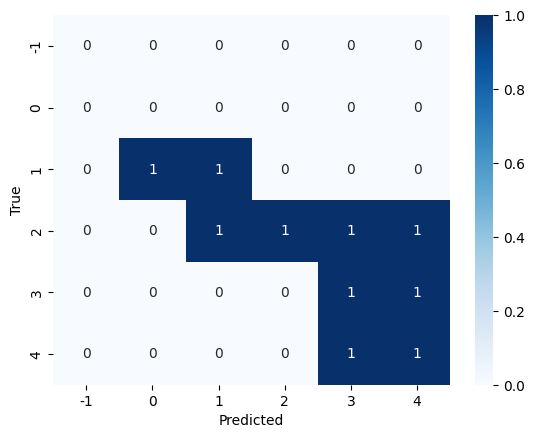

In [16]:
# 混同行列で結果を可視化

label_name = list(range(-1, 5))  # [-1, 0, .., 4]

# 混同行列の作成
confusion_mtr = confusion_matrix(label_list, predict_label_list, labels=label_name)

# ラベル名
label_name = list(range(-1, 5))

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### テストデータを用いた評価

* few-shotプロンプトを用いてテストデータをレビュー分類
  * 検証データについてfew-shotプロンプトを用いた結果が良かったため

In [17]:
test_review_list = shuffled_dataset[-k:]["text"]
test_label_list = shuffled_dataset[-k:]["label"]
print(test_review_list)
print(test_label_list)

['米の味がイマイチ。パサついていて味が無い。\n\nタイカレーのライスや、チャーハンにするには良いかもしれない。便利なサイズで便利なパックだけど、他社の製品と比べると米のもっちり感や旨みが乏しい。', 'いいですね\n\nスマホにピッタリ合ってます。持っても滑りにくう、本体への傷を心配せずに使用できますね。', '使えます\n\nボートのオールが左右一本ずつで付け外しが面倒だったので買いました接続は片方にピンがありもう片方にピンが入る穴が三箇所空いていてオールの向きを並行とクロスにすることが出来ます。ボートを押す離岸にも使えました。 黒い部分は黒く塗ってあるのかな艶のあるビニールなのかもしれませんが濡れたら滑り止めには成らないようです。 私は一人乗りのボートに使っています。', '先端が割れてしまいます。\n\n安いので、こんなもんでしょう。先端を削って再度使います。', '金属ピアス用\n\n樹脂ピアス用に買ったのですが、太さ的に無理でした(笑)ですが金属ピアスにはちょうどいいサイズなので使っています。', 'サブとして\n\nまず、点火の仕方がわからない。適当に連打して 使える時があります。確かに吸えますが、燃えています。アイコスが壊れた時に置いておくつもりで買いました。', 'ちょっと難しい\n\n資格を取るための勉強にと購入しました。 Progateで一通り基礎が分かればいい勉強になると思います', '根気良く続ければ、薄くなります\n\n1年くらい使っていますが、薄くはなりました。2ヶ月くらいで薄くなったと実感。その後はそれ以上薄くならず、途中使っていなかった時期もありましたが、再開。完全に消すのは難しいでしょうが、また薄くなって来たと実感できています。化粧水の横に置いて、徹底することが大切ですね。コスパ的には、悪くはないと思います。', '基本的には満足してます\n\nタイマーがもう少し長いと嬉しい。 あともう少し広い面に風を送りたいので羽根のサイズはもう少し大きくてもいいかな。', '効果なし\n\n北海道在住、海の近くで日光浴をするために使用していましたが、全く効き目なし。 全身にかけて、服にもチェアーにかけてましたが、気づいたら顎に刺されてた。かゆい… アブは平気で向かってくるし、なんか刺されるし、スプレータイプは個人的にやはり信用できません。 

In [18]:
# テストデータで評価
## 最も良かったfew-shotプロンプトを使用

predict_label_list = [] # -1(出力形式のエラー), 0, 1, 2, 3, 4
total_credit = 0
for i, (review, label) in enumerate(zip(test_review_list, test_label_list)):
    # user_prompt = "レビュー文: " + review + "\n評価: "
    user_prompt = "レビュー文: " + review + "\n"
    print(f"\n^^^^^^^^^^ {i+1}件目のレビュー ^^^^^^^^^^")
    print("--- レビュー文 ---")
    print(user_prompt)
    print("--- 実際の評価 ---")
    print(label)
    response, credit = simple_completion(system_prompt, user_prompt)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    try:
        response_int = int(response.choices[0].message.content)
        predict_label_list.append(response_int)
    except ValueError:
        print("--- Error ---")
        print("回答がint型に変換できませんでした。")
        predict_label_list.append(-1)
        continue
print(f"合計金額: {total_credit}円")


^^^^^^^^^^ 1件目のレビュー ^^^^^^^^^^
--- レビュー文 ---
レビュー文: 米の味がイマイチ。パサついていて味が無い。

タイカレーのライスや、チャーハンにするには良いかもしれない。便利なサイズで便利なパックだけど、他社の製品と比べると米のもっちり感や旨みが乏しい。

--- 実際の評価 ---
1
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.1円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbCW0uZcxl6BP76R9g3n2bWAiX4M', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='1', role='assistant', function_call=None, tool_calls=None))], created=1702303532, model='gpt-3.5-turbo-1106', object='chat.completion', system_fingerprint='fp_eeff13170a', usage=CompletionUsage(completion_tokens=1, prompt_tokens=671, total_tokens=672))
1

^^^^^^^^^^ 2件目のレビュー ^^^^^^^^^^
--- レビュー文 ---
レビュー文: いいですね

スマホにピッタリ合ってます。持っても滑りにくう、本体への傷を心配せずに使用できますね。

--- 実際の評価 ---
3
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.09円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbCY2qrpU0WUMiC2H2xNFNGprwOM', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='3', role='assistant', function_call=None, tool_call

In [19]:
print("--- 実際の評価 ---")
print(test_label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)
## 予測した評価が-1（出力形式のエラー）の場合は+6

validation_score = 0 # 評価値
correct_answer = 0 # 正解数
for actual, predict in zip(test_label_list, predict_label_list):
    if not actual == predict:
        if predict == -1:
            validation_score += 6
            continue
        validation_score += abs(actual - predict)
    else:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(test_label_list)*100} %")
print("--- 評価値 (低いほうが良い結果) ---")
print(validation_score)

--- 実際の評価 ---
[1, 3, 2, 1, 3, 1, 3, 2, 2, 0]
--- 予測した評価--- 
[1, 3, 3, 2, 2, 1, 2, 3, 2, 1]

--- 正答率 ---
40.0 %
--- 評価値 (低いほうが良い結果) ---
6


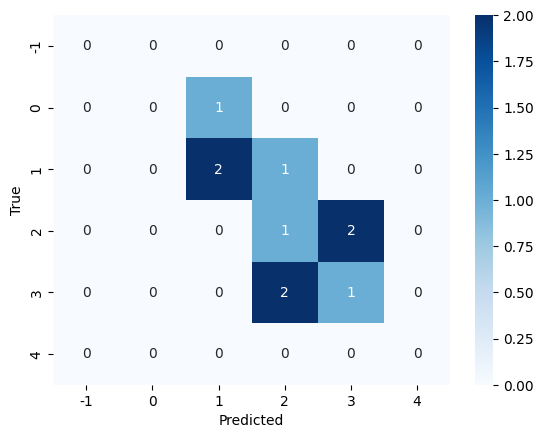

In [20]:
# 混同行列で結果を可視化

label_name = list(range(-1, 5))  # [-1, 0, .., 4]

# 混同行列の作成
confusion_mtr = confusion_matrix(test_label_list, predict_label_list, labels=label_name)

# ラベル名
label_name = list(range(-1, 5))

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 演習課題例②: **ニュース記事からカテゴリ分類**

* Yahooニュースからニュース記事の概要、カテゴリを収集
  * スポーツ、経済の2カテゴリからランダムに
  * スポーツと経済のどちらにも該当するケースは選ばないように収集
  * 合わせて24記事収集 (スポーツ12記事、経済12記事)
  * Googleスプレッドシートを使用し、カテゴリ、文章の2つを手作業で記入

* ChatGPTによるカテゴリ分類
  * zero-shotプロンプトを使用した例
  * few-shotプロンプトを使用した例

### 記事の収集とデータの読み込み

* 各自で設定した課題に関するデータを収集してください

* 今回の例では、以下のリンクのスプレッドシートを作成したと想定する
  * https://docs.google.com/spreadsheets/d/1eJV-uRF1Mbpt_MokNfMvFewarMBsqWfM32W5_HdGvow/edit?usp=sharing

  * 以下より、スプレッドシートをダウンロード

<img src="https://drive.google.com/uc?export=view&id=1SdXP1PMFsQtkAgqyhlL-W9npfxYHJWGY" width=50%>


* ダウンロードしたデータをColab上にアップロード

<img src="https://drive.google.com/uc?export=view&id=1YVJhXYVCEehBF_li5EiWjUxiwKepnaFY" width=50%>

In [21]:
SEED = 1000

# スプレッドシートの読み込み
df = pd.read_excel("yahoo_news_dataset.xlsx")  #TODO: ここを各々のデータに置き換える

df = df.sample(frac=1, random_state=SEED)  # データをシャッフル

df.head()

,カテゴリ,文章
5,スポーツ,高校野球界の名将で、広島県立竹原高校野球部監督の迫田穆成さんが、亡くなりました。84歳でした。
22,経済,イオンは３０日、首都圏でスーパーを展開する「いなげや」を１１月２９日付で連結子会社化したと発...
3,スポーツ,巨人のオコエ瑠偉外野手が28日、東京都内の球団事務所で契約更改交渉に臨み、250万円増の年俸...
6,スポーツ,ソウルオリンピック銅メダリストであり、今年8月に行われた「世界マスターズ水泳選手権2023九...
23,経済,新型コロナの分類が5類に移行してから初めての年末年始ということで、移動する方が多いと思います...


In [22]:
k = 10 # 10件のレビュー文に対する評価

# 検証データ
review_list = df[:k]["文章"].values.tolist()     # 入力文章が格納されている列名
label_list = df[:k]["カテゴリ"].values.tolist()  # カテゴリ、ラベルが格納されている列名

# few-shotデータ
num_few_shot = 4  # few-shotの数
review_list_few_shot = df[k: k + num_few_shot]["文章"].values.tolist()
label_list_few_shot = df[k: k + num_few_shot]["カテゴリ"].values.tolist()

# テストデータ
test_review_list = df[-k:]["文章"].values.tolist()
test_label_list = df[-k:]["カテゴリ"].values.tolist()

### 検証データによる評価

#### zero-shotプロンプトによるカテゴリ分類

* 検証データを用いたレビュー分類
* 回答例を与えないzero-shotプロンプトを使用

In [23]:

# zero-shotプロンプト
system_prompt = """
文章を経済または、スポーツに分類してください。
'経済'もしくは'スポーツ'のどちらかで回答してください。
"""

predict_label_list = []  # '経済', 'スポーツ'
total_credit = 0
for i, (text, label) in enumerate(zip(review_list, label_list)):
    # print(text)
    # print(label)
    # break
    print(f"\n^^^^^^^^^^ 記事{i+1} ^^^^^^^^^^")
    print("--- 文章 ---")
    print(text)
    print("--- 実際のカテゴリ ---")
    print(label)
    response, credit = simple_completion(system_prompt, text)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    predict_label_list.append(response.choices[0].message.content)
print(f"合計金額: {total_credit}円")


^^^^^^^^^^ 記事1 ^^^^^^^^^^
--- 文章 ---
高校野球界の名将で、広島県立竹原高校野球部監督の迫田穆成さんが、亡くなりました。84歳でした。
--- 実際のカテゴリ ---
スポーツ
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.02円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbCky6915K0CtlBH0oZS5MmWtSQ2', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='スポーツ', role='assistant', function_call=None, tool_calls=None))], created=1702303546, model='gpt-3.5-turbo-1106', object='chat.completion', system_fingerprint='fp_eeff13170a', usage=CompletionUsage(completion_tokens=4, prompt_tokens=116, total_tokens=120))
スポーツ

^^^^^^^^^^ 記事2 ^^^^^^^^^^
--- 文章 ---
イオンは３０日、首都圏でスーパーを展開する「いなげや」を１１月２９日付で連結子会社化したと発表した。
--- 実際のカテゴリ ---
経済
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.02円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbClabE6WURlZ3nQ7l9R5gYoRTTo', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='経済', role='assistant', function_call=None, tool_calls=None))], created=1702303547, model='gpt-3.5-turbo-1106', objec

In [24]:
print("--- 実際の評価 ---")
print(label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)

correct_answer = 0 # 正解数
for actual, predict in zip(label_list, predict_label_list):
    if actual == predict:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(label_list)*100} %")

--- 実際の評価 ---
['スポーツ', '経済', 'スポーツ', 'スポーツ', '経済', '経済', 'スポーツ', '経済', '経済', '経済']
--- 予測した評価--- 
['スポーツ', '経済', 'スポーツ', 'スポーツ', '経済', '経済', 'スポーツ', '経済', '経済', '経済']

--- 正答率 ---
100.0 %


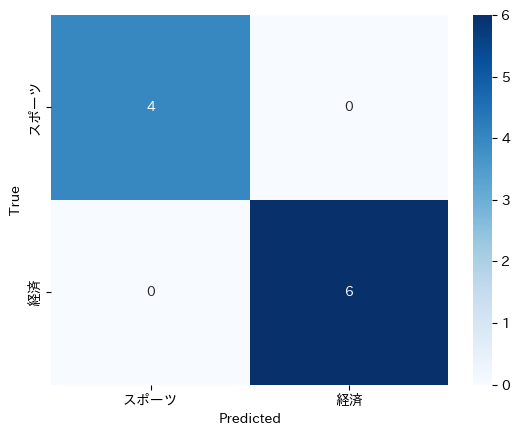

In [25]:
# 混同行列で結果を可視化
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# 混同行列に使用するユニークなラベル作成
label_name = list(set(label_list + predict_label_list))  # ['経済', 'スポーツ']

# 混同行列の作成
confusion_mtr = confusion_matrix(label_list, predict_label_list, labels=label_name)

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

zero-shotプロンプトで良い精度だったので、このプロンプトでテストデータを評価

### テストデータを分類

In [26]:
# zero-shotプロンプト
system_prompt = """
文章を経済または、スポーツに分類してください。
'経済'もしくは'スポーツ'のどちらかで回答してください。
"""

predict_label_list = []  # '経済', 'スポーツ'
total_credit = 0
for i, (text, label) in enumerate(zip(test_review_list, test_label_list)):
    # print(text)
    # print(label)
    # break
    print(f"\n^^^^^^^^^^ 記事{i+1} ^^^^^^^^^^")
    print("--- 文章 ---")
    print(text)
    print("--- 実際のカテゴリ ---")
    print(label)
    response, credit = simple_completion(system_prompt, text)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    predict_label_list.append(response.choices[0].message.content)
print(f"合計金額: {total_credit}円")


^^^^^^^^^^ 記事1 ^^^^^^^^^^
--- 文章 ---
先週のジャパンＣでＧ１・６連勝となったイクイノックス（牡４歳、美浦・木村哲也厩舎、父キタサンブラック）が現役を引退することが１１月３０日、分かった。馬主であるシルクホースクラブがホームページで発表した。ジャパンＣ後に疲労があり、万全の状態で有馬記念・Ｇ１（１２月２４日）へ向かうことが難しいと判断されたため。今後は北海道の社台スタリオンステーションで種牡馬になる予定。
--- 実際のカテゴリ ---
スポーツ
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.04円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbD5sWykNDqhBw2Marsj6t8N68ny', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='スポーツ', role='assistant', function_call=None, tool_calls=None))], created=1702303567, model='gpt-3.5-turbo-1106', object='chat.completion', system_fingerprint='fp_eeff13170a', usage=CompletionUsage(completion_tokens=4, prompt_tokens=270, total_tokens=274))
スポーツ

^^^^^^^^^^ 記事2 ^^^^^^^^^^
--- 文章 ---
2025年の大阪・関西万博をめぐり、28日、ロシアが参加しないことを正式に表明しました。
--- 実際のカテゴリ ---
経済
使用したモデル: gpt-3.5-turbo-1106, 料金: 0.02円
--- ChatGPTの回答 ---
ChatCompletion(id='chatcmpl-8UbD6r2TcLno7VSoB9fsQAtXQR7Od', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMe

In [27]:
print("--- 実際の評価 ---")
print(test_label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)

correct_answer = 0 # 正解数
for actual, predict in zip(test_label_list, predict_label_list):
    if actual == predict:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(test_label_list)*100} %")

--- 実際の評価 ---
['スポーツ', '経済', 'スポーツ', 'スポーツ', '経済', '経済', 'スポーツ', 'スポーツ', 'スポーツ', '経済']
--- 予測した評価--- 
['スポーツ', '経済', 'スポーツ', 'スポーツ', '経済', '経済', 'スポーツ', 'スポーツ', 'スポーツ', '経済']

--- 正答率 ---
100.0 %


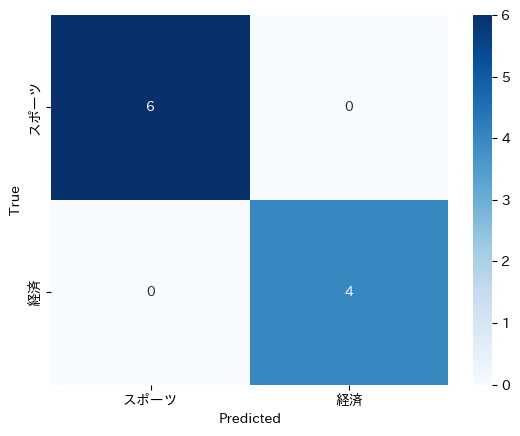

In [28]:
# 混同行列に使用するユニークなラベル作成
label_name = list(set(test_label_list + predict_label_list))  # ['経済', 'スポーツ']

# 混同行列の作成
confusion_mtr = confusion_matrix(test_label_list, predict_label_list, labels=label_name)

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()